In [ ]:
!pip install pandas networkx matplotlib
!pip install pyvis
!conda install pandas networkx matplotlib -c conda-forge
!pip install python-louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00
/bin/bash: line 1: conda: command not found


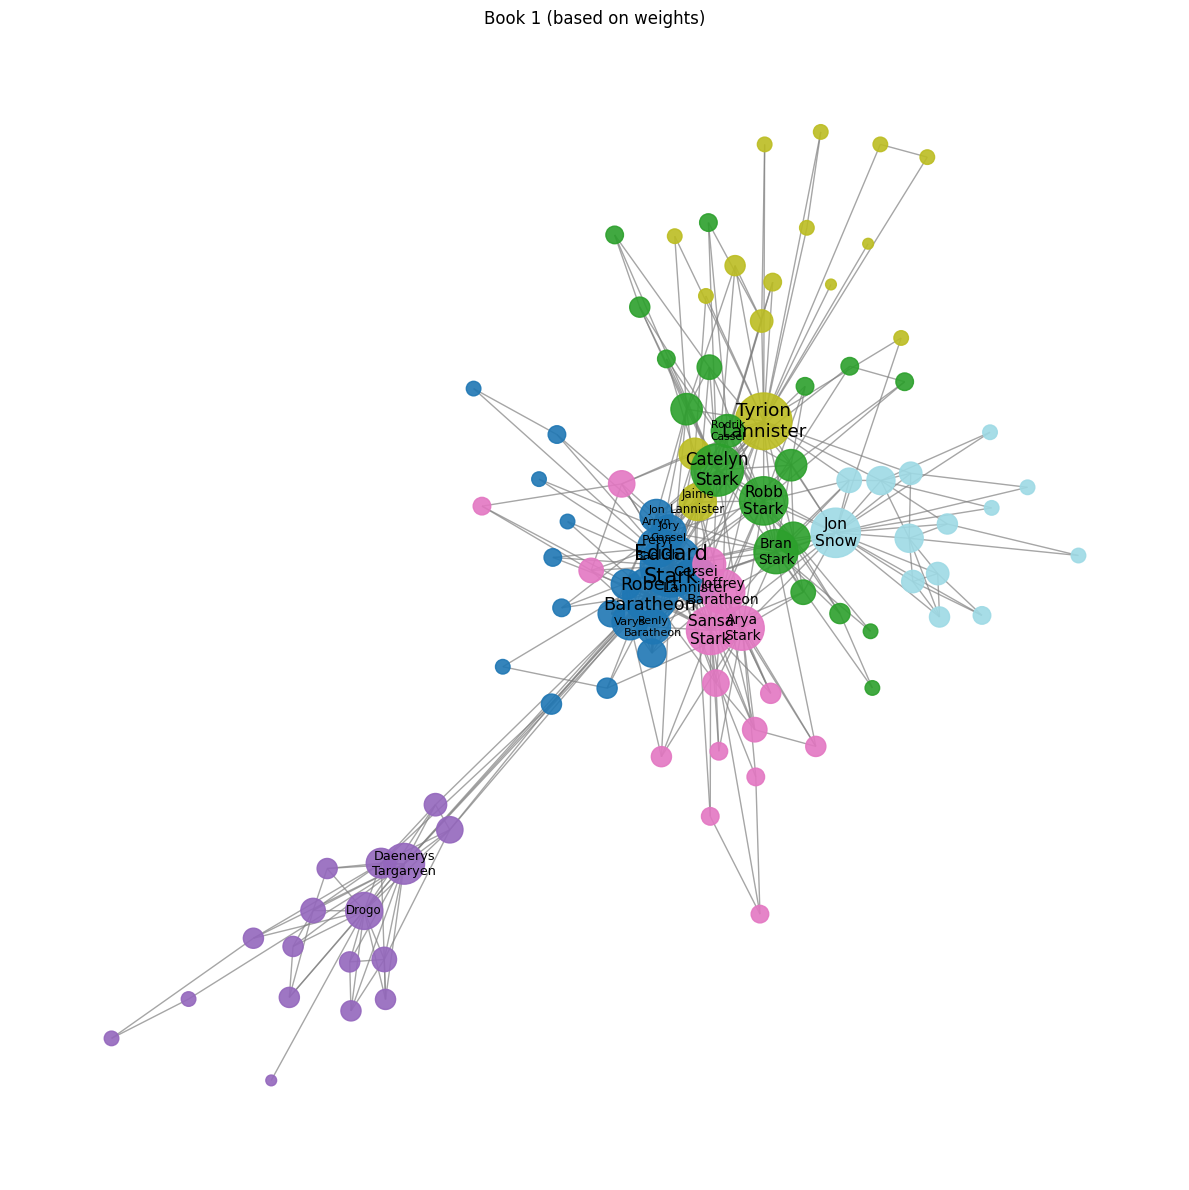

In [ ]:
# Book 1, distance = weight, community_forming menthod = Fast Greedy
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt


# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book1.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("Book 1 (based on weights)")
plt.tight_layout()
plt.show()

[('Eddard-Stark', 0.5683228245324445), ('Robert-Baratheon', 0.5211614493974357), ('Cersei-Lannister', 0.23899713277246154), ('Catelyn-Stark', 0.1824150179238331), ('Petyr-Baelish', 0.18194784245902468), ('Sansa-Stark', 0.18161387632772222), ('Joffrey-Baratheon', 0.1666301053178685), ('Jon-Snow', 0.1626852554501368), ('Varys', 0.1543306643179533), ('Tyrion-Lannister', 0.14795792486857226)]
['Eddard-Stark', 'Tyrion-Lannister', 'Robert-Baratheon', 'Catelyn-Stark', 'Jon-Snow', 'Robb-Stark', 'Sansa-Stark', 'Cersei-Lannister', 'Arya-Stark', 'Bran-Stark']


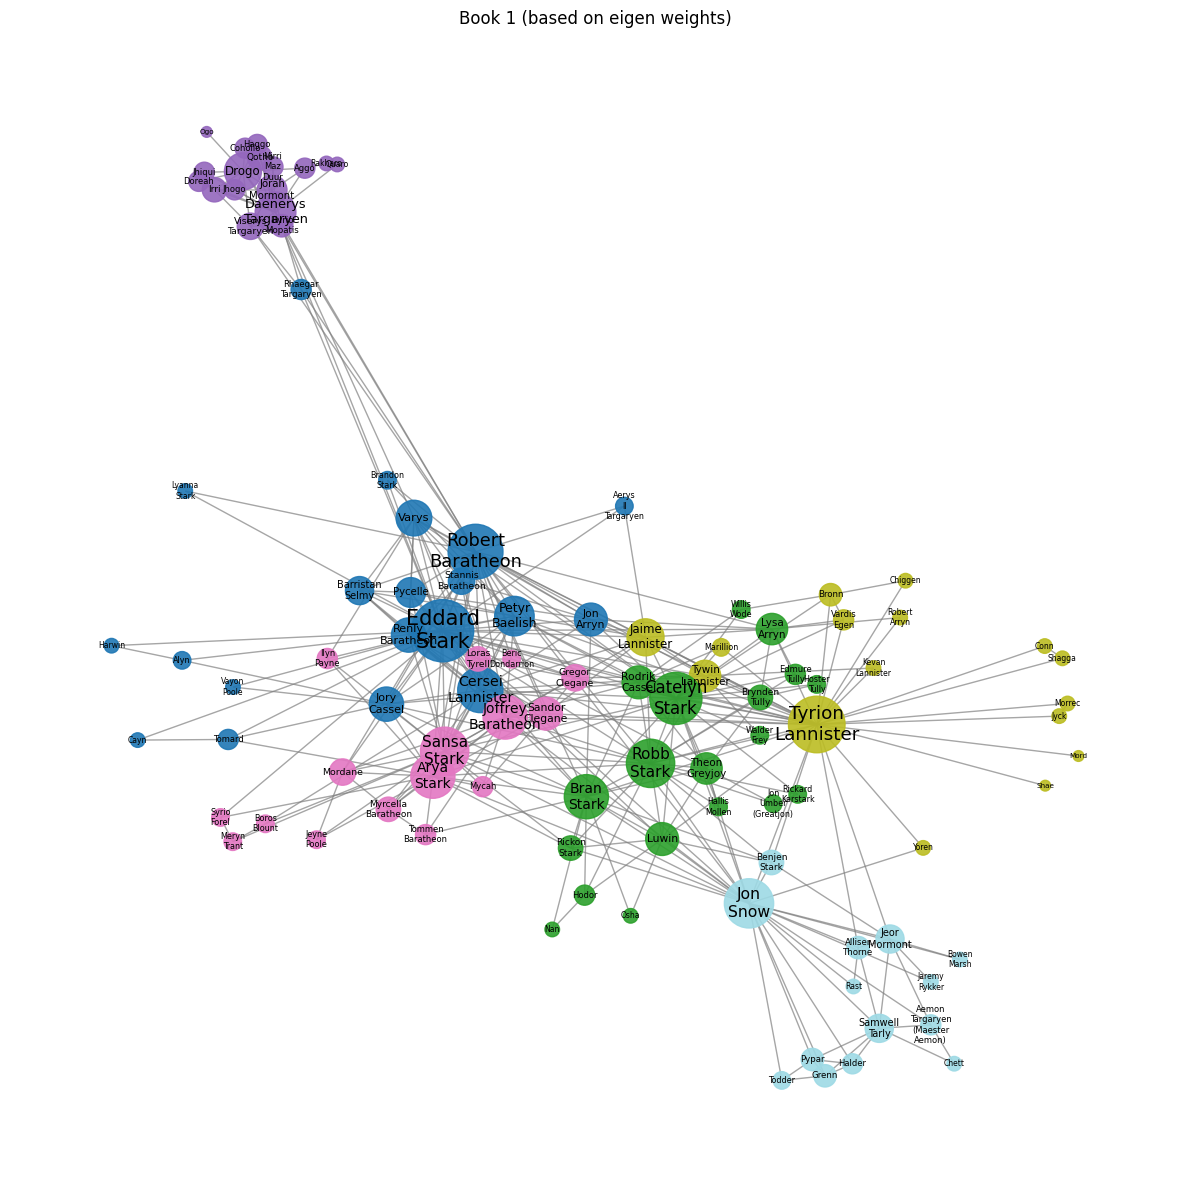

In [12]:
# Book 1, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book1.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )
print(sorted(ec.items(), key = lambda x :-x[1])[:10])
print(top_labels[:10])
plt.axis('off')
plt.title("Book 1 (based on eigen weights)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from networkx.algorithms.centrality import eigenvector_centrality

# === 1. Load Data ===
df = pd.read_csv("/content/Untitled Folder/book1.csv")  # update to your correct path

# === 2. Build and Filter Graph ===
G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr='weight', create_using=nx.Graph())

# 2a. Filter edges by weight
edge_thresh = 5
G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < edge_thresh])

# 2b. Filter nodes by weighted degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
G.remove_nodes_from([n for n, w in deg.items() if w < node_thresh])

# === 3. Centrality and Layout ===
ec = eigenvector_centrality(G, weight='weight', max_iter=1000)

# Inverse eigenvector centrality weight for layout
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

pos = nx.spring_layout(G, weight='ec_weight', k=0.6, scale=6.0, iterations=500, seed=42)

# === 4. Node Sizes by Degree ===
deg = dict(G.degree(weight='weight'))
max_deg = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# === 5. Assign Houses ===
def assign_house(node):
    parts = node.split('-')
    return parts[-1] if len(parts) > 1 else None

house_lookup = {node: assign_house(node) for node in G.nodes()}
houses = sorted(set(h for h in house_lookup.values() if h is not None))
cmap = cm.get_cmap('tab20', len(houses))
house_to_color = {house: mcolors.to_hex(cmap(i)) for i, house in enumerate(houses)}
house_to_color[None] = "#888888"
node_house_colors = [house_to_color[house_lookup[n]] for n in G.nodes()]

# === 6. Draw Graph ===
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, width=1, alpha=0.7, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_house_colors, alpha=0.9)

# Label top 10 characters by degree
top_labels = sorted(deg, key=deg.get, reverse=True)[:10]
for n in top_labels:
    x, y = pos[n]
    plt.text(
        x, y, n.replace('-', '\n'),
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black'
    )

# Add a legend for house colors
for house, color in house_to_color.items():
    plt.scatter([], [], c=color, label=house or "None", s=60)
plt.legend(title="House", loc='upper left', fontsize='small', frameon=True)

plt.axis('off')
plt.title("Book 1 — Nodes Colored by House")
plt.tight_layout()
plt.show()


/tmp/ipython-input-11-1821817444.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(houses))


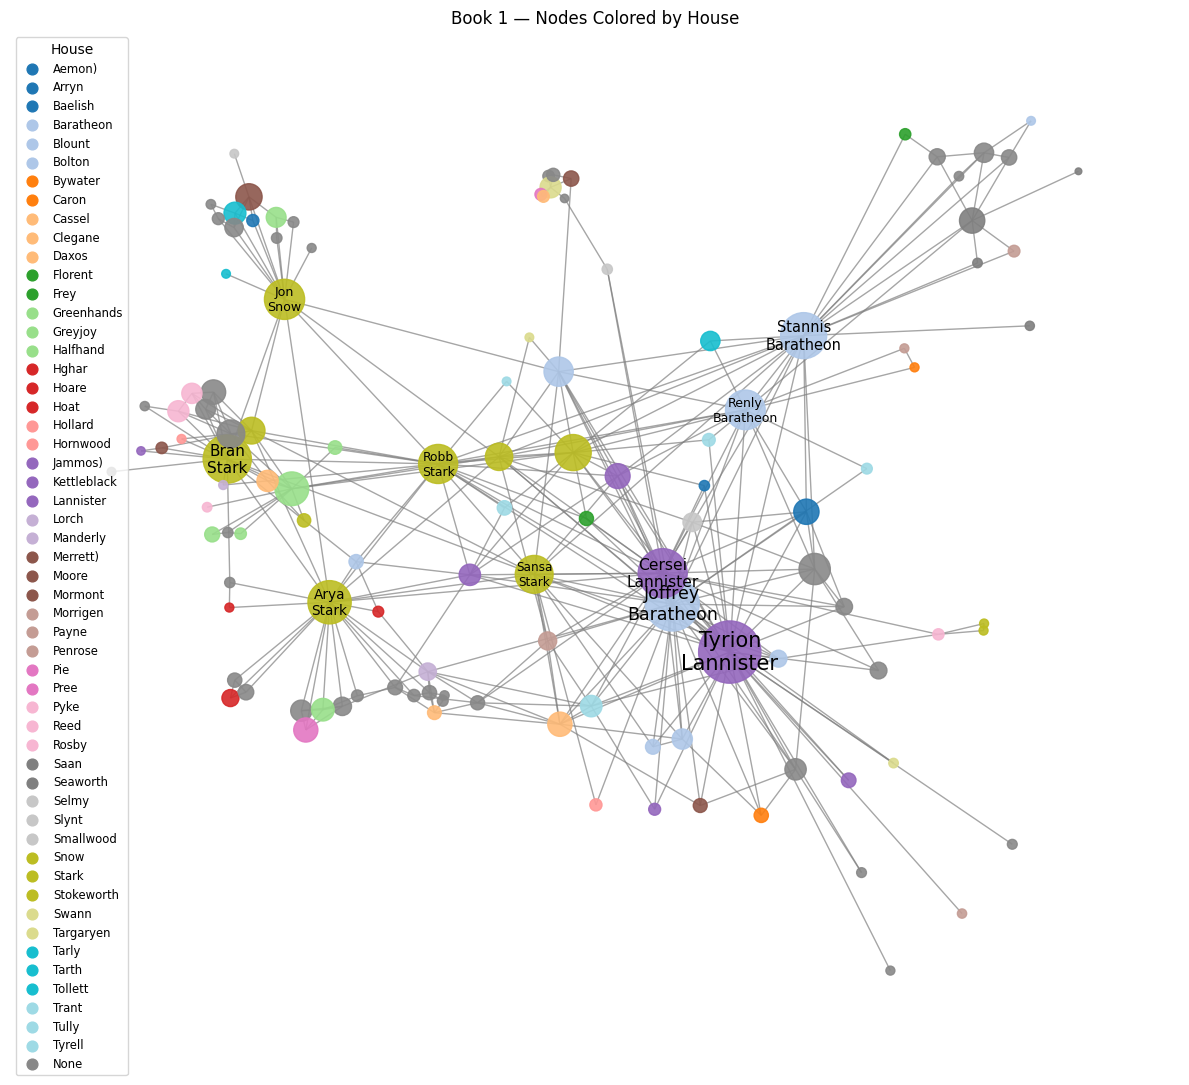

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from networkx.algorithms.centrality import eigenvector_centrality

# === 1. Load Data ===
df = pd.read_csv("/content/Untitled Folder/book2.csv")  # update to your correct path

# === 2. Build and Filter Graph ===
G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr='weight', create_using=nx.Graph())

# 2a. Filter edges by weight
edge_thresh = 5
G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < edge_thresh])

# 2b. Filter nodes by weighted degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
G.remove_nodes_from([n for n, w in deg.items() if w < node_thresh])

# === 3. Centrality and Layout ===
ec = eigenvector_centrality(G, weight='weight', max_iter=1000)

# Inverse eigenvector centrality weight for layout
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

pos = nx.spring_layout(G, weight='ec_weight', k=0.6, scale=6.0, iterations=500, seed=42)

# === 4. Node Sizes by Degree ===
deg = dict(G.degree(weight='weight'))
max_deg = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# === 5. Assign Houses ===
def assign_house(node):
    parts = node.split('-')
    return parts[-1] if len(parts) > 1 else None

house_lookup = {node: assign_house(node) for node in G.nodes()}
houses = sorted(set(h for h in house_lookup.values() if h is not None))
cmap = cm.get_cmap('tab20', len(houses))
house_to_color = {house: mcolors.to_hex(cmap(i)) for i, house in enumerate(houses)}
house_to_color[None] = "#888888"
node_house_colors = [house_to_color[house_lookup[n]] for n in G.nodes()]

# === 6. Draw Graph ===
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, width=1, alpha=0.7, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_house_colors, alpha=0.9)

# Label top 10 characters by degree
top_labels = sorted(deg, key=deg.get, reverse=True)[:10]
for n in top_labels:
    x, y = pos[n]
    plt.text(
        x, y, n.replace('-', '\n'),
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black'
    )

# Add a legend for house colors
for house, color in house_to_color.items():
    plt.scatter([], [], c=color, label=house or "None", s=60)
plt.legend(title="House", loc='upper left', fontsize='small', frameon=True)

plt.axis('off')
plt.title("Book 1 — Nodes Colored by House")
plt.tight_layout()
plt.show()


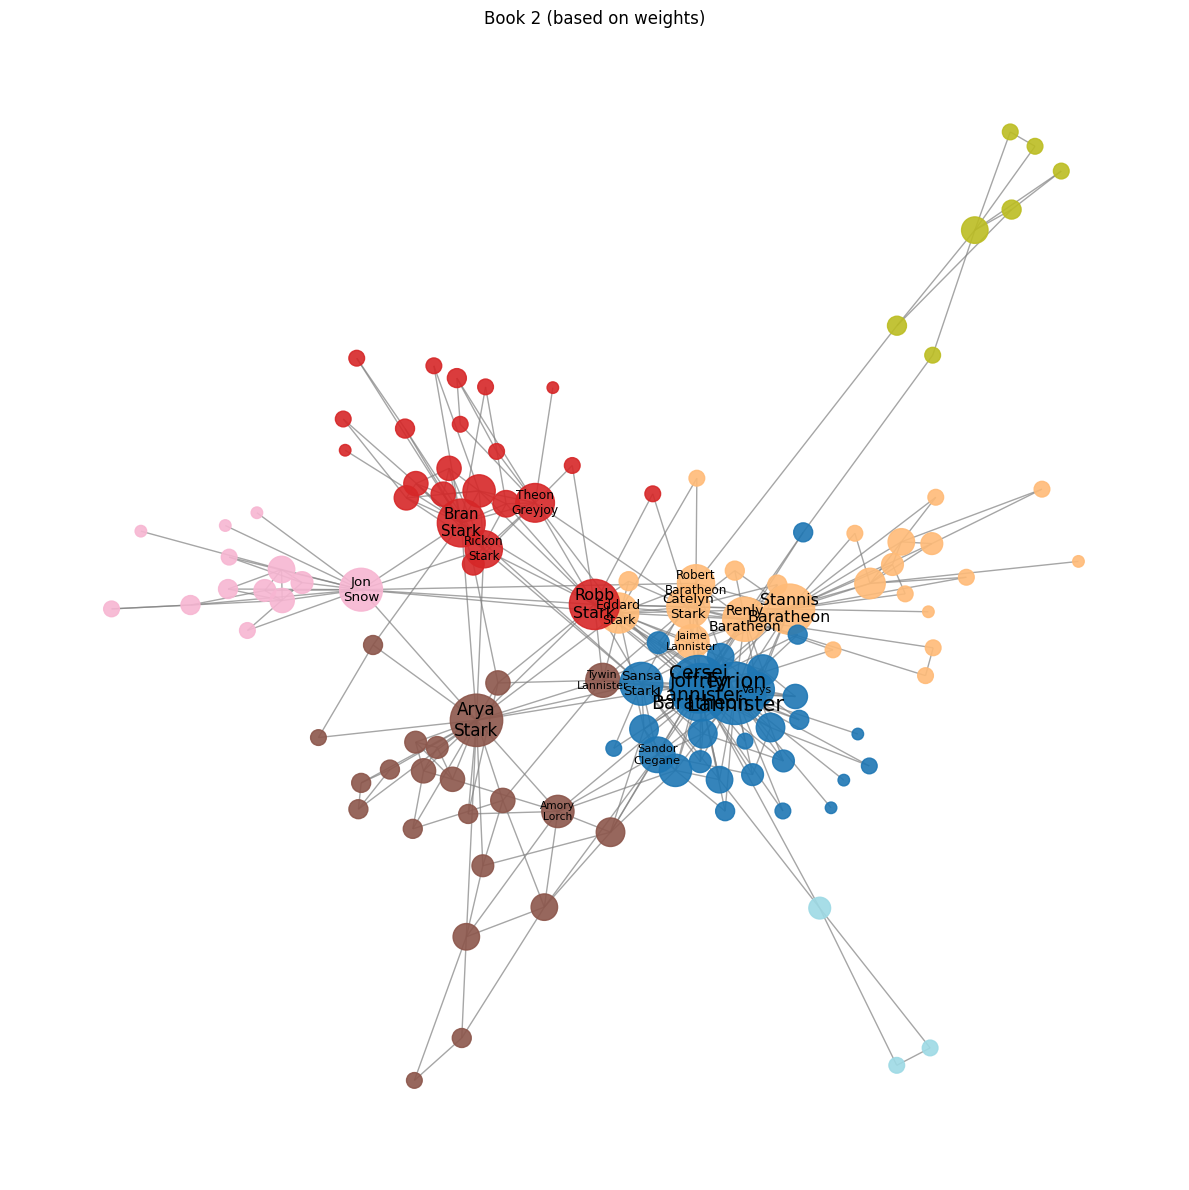

In [ ]:
# Book 2, distance = weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book2.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',

    )

plt.axis('off')
plt.title("Book 2 (based on weights)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2-808227598.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(houses))


   Community  Purity Dominant House  Size
0          1   0.103      Lannister    29
1          2   0.167      Baratheon    24
2          3   0.174        Greyjoy    23
3          4   0.045      Lannister    22
4          5   0.077        Mormont    13
5          6   0.143        Mormont     7
6          7   0.667     Stokeworth     3


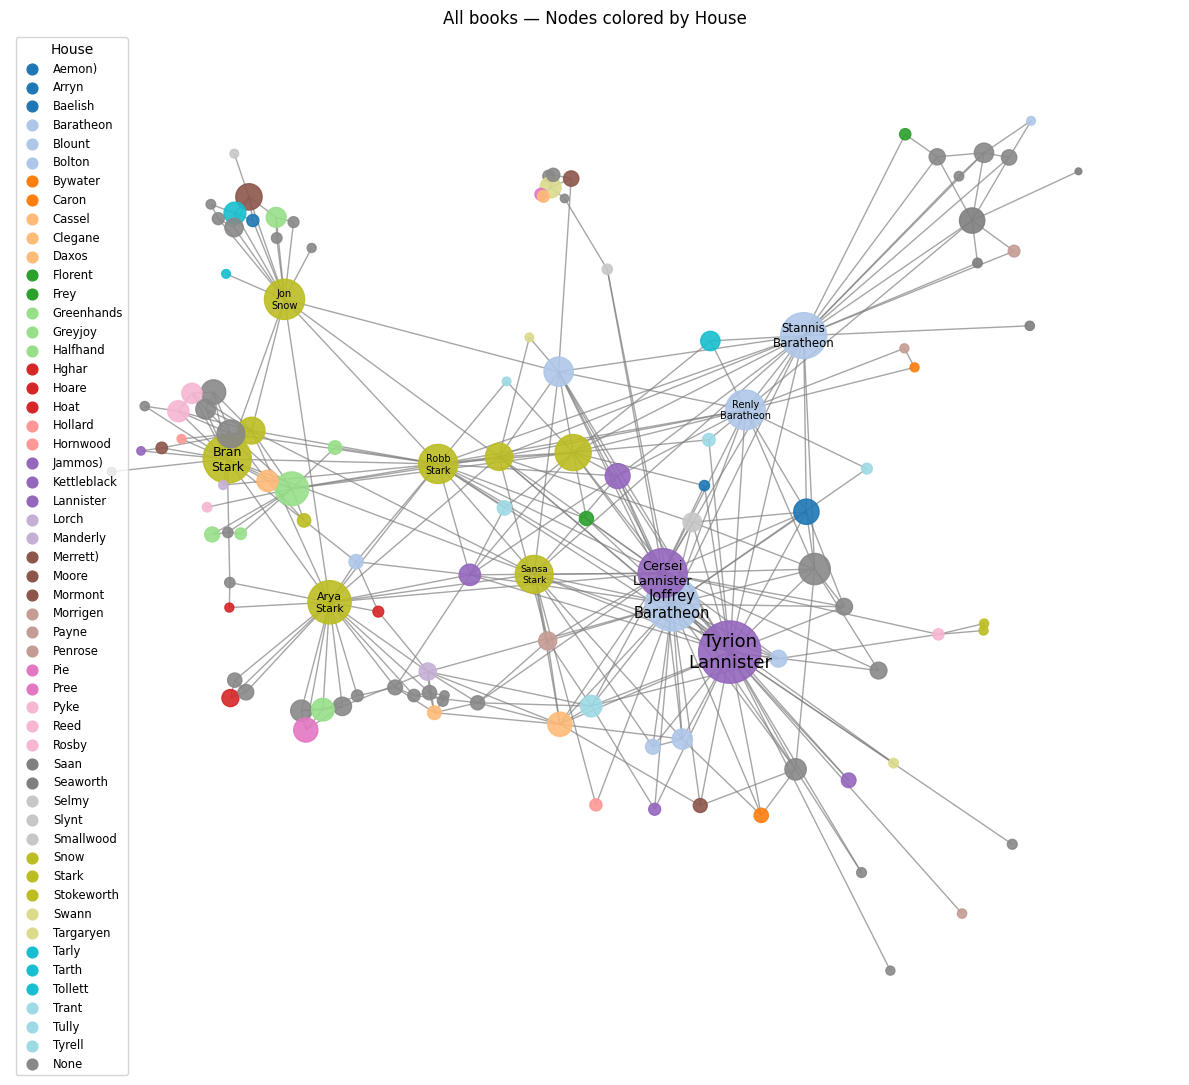

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from networkx.algorithms.centrality import eigenvector_centrality
from networkx.algorithms.community import greedy_modularity_communities, modularity

# === STEP 1: Load the data ===
df = pd.read_csv("/content/Untitled Folder/book2.csv")  # replace with your own path

SRC_COL = "Source"
TGT_COL = "Target"
WEIGHT_COL = "weight"

G = nx.from_pandas_edgelist(df, source=SRC_COL, target=TGT_COL, edge_attr=WEIGHT_COL, create_using=nx.Graph())

# === STEP 2: Filter the network ===
edge_thresh = 5
G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d[WEIGHT_COL] < edge_thresh])

deg = dict(G.degree(weight=WEIGHT_COL))
node_thresh = 10
G.remove_nodes_from([n for n, w in deg.items() if w < node_thresh])

# === STEP 3: Community detection ===
comms = list(greedy_modularity_communities(G, weight=WEIGHT_COL))
partition = {node: ci for ci, com in enumerate(comms) for node in com}
node_colors = [partition[n] for n in G.nodes()]
Q = modularity(G, comms, weight=WEIGHT_COL)

# === STEP 4: Centrality + layout weight ===
ec = eigenvector_centrality(G, weight=WEIGHT_COL, max_iter=1000)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

pos = nx.spring_layout(G, weight='ec_weight', k=0.6, scale=6.0, iterations=500, seed=42)

# === STEP 5: Node size and labels ===
deg = dict(G.degree(weight=WEIGHT_COL))
max_deg = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# === STEP 6: Assign Houses from names ===
def assign_house(node):
    parts = node.split('-')
    return parts[-1] if len(parts) > 1 else None

house_lookup = {node: assign_house(node) for node in G.nodes()}
houses = sorted(set(h for h in house_lookup.values() if h is not None))
cmap = cm.get_cmap('tab20', len(houses))
house_to_color = {house: mcolors.to_hex(cmap(i)) for i, house in enumerate(houses)}
house_to_color[None] = "#888888"
node_house_colors = [house_to_color[house_lookup[n]] for n in G.nodes()]

# === STEP 7: Compute Community Purity ===
def compute_purity(communities, house_lookup):
    results = []
    for i, community in enumerate(communities):
        houses = [house_lookup.get(n) for n in community if house_lookup.get(n) is not None]
        total = len(community)
        if houses:
            dominant = max(set(houses), key=houses.count)
            dominant_count = houses.count(dominant)
            purity = dominant_count / total
        else:
            dominant = "None"
            purity = 0
        results.append({
            "Community": i + 1,
            "Purity": round(purity, 3),
            "Dominant House": dominant,
            "Size": total
        })
    return results

purity_stats = compute_purity(comms, house_lookup)
df_purity = pd.DataFrame(purity_stats)
print(df_purity)

# === STEP 8: Plot the graph ===
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, width=1, alpha=0.7, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_house_colors, alpha=0.9)

# Label top characters by degree
top_labels = sorted(deg, key=deg.get, reverse=True)[:10]
for n in top_labels:
    x, y = pos[n]
    plt.text(x, y, n.replace('-', '\n'), fontsize= 3 + (deg[n]/max_deg)*10, ha='center', va='center', color='black')

# Optional: Add a legend for houses
for house, color in house_to_color.items():
    plt.scatter([], [], c=color, label=house or "None", s=60)
plt.legend(title="House", loc='upper left', fontsize='small', frameon=True)

plt.title("All books — Nodes colored by House")
plt.axis('off')
plt.tight_layout()
plt.show()



[('Tyrion-Lannister', 0.5039376792307406), ('Joffrey-Baratheon', 0.44412660423608463), ('Cersei-Lannister', 0.3963550157268864), ('Sansa-Stark', 0.26585961747274434), ('Stannis-Baratheon', 0.24104702409564646), ('Varys', 0.21442681500125868), ('Renly-Baratheon', 0.17683424912774912), ('Petyr-Baelish', 0.14763762032719077), ('Robb-Stark', 0.1463012807338341), ('Robert-Baratheon', 0.12646833552813772)]
['Tyrion-Lannister', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Arya-Stark', 'Stannis-Baratheon', 'Robb-Stark', 'Bran-Stark', 'Renly-Baratheon', 'Jon-Snow', 'Sansa-Stark']


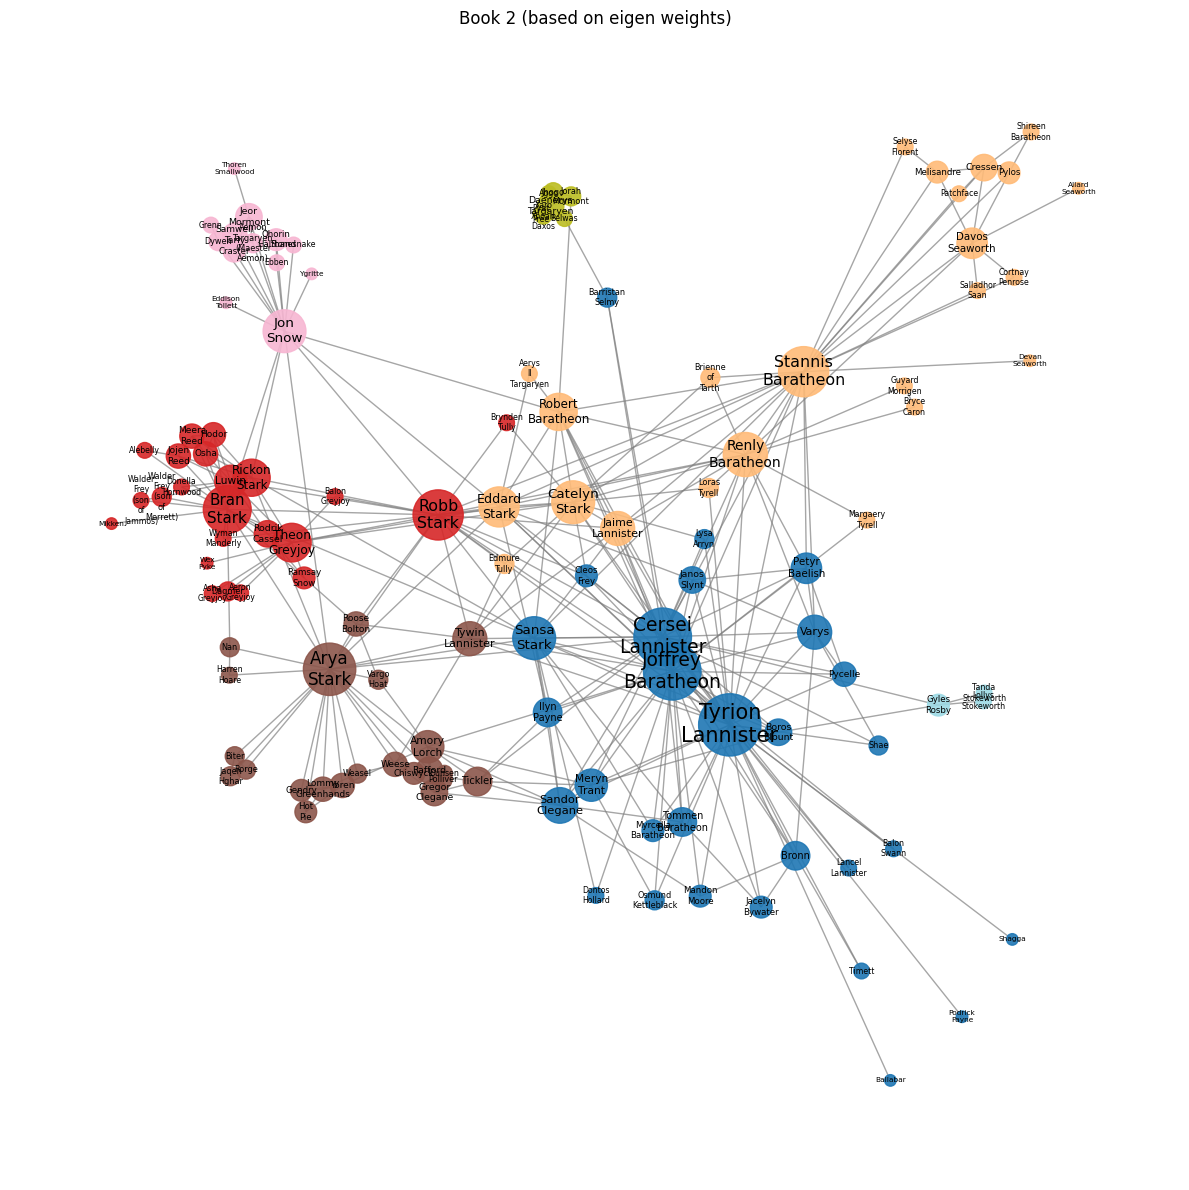

In [ ]:
# Book 2, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book2.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )
print(sorted(ec.items(), key = lambda x :-x[1])[:10])
print(top_labels[:10])
plt.axis('off')
plt.title("Book 2 (based on eigen weights)")
plt.tight_layout()
plt.show()

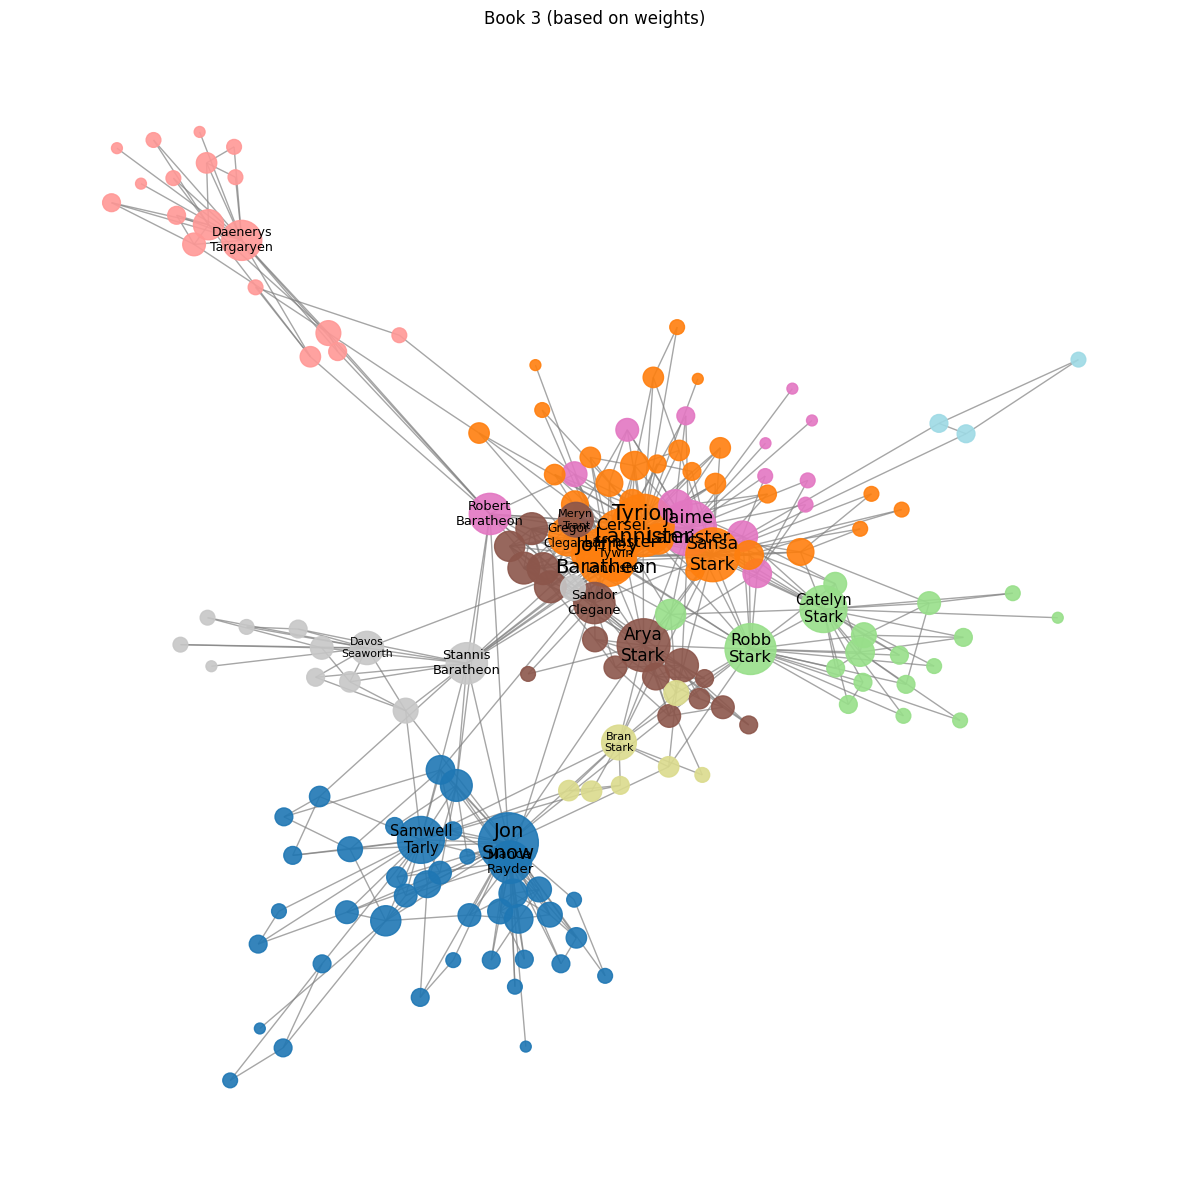

In [ ]:
# Book 3, distance = weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book3.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',

    )

plt.axis('off')
plt.title("Book 3 (based on weights)")
plt.tight_layout()
plt.show()

[('Tyrion-Lannister', 0.502869452065732), ('Joffrey-Baratheon', 0.4343708260772972), ('Sansa-Stark', 0.3599304937811044), ('Cersei-Lannister', 0.2900521806099431), ('Jaime-Lannister', 0.26113946651860787), ('Tywin-Lannister', 0.1956471780601256), ('Robb-Stark', 0.1525299503109418), ('Margaery-Tyrell', 0.15168991345220684), ('Oberyn-Martell', 0.129283269296643), ('Arya-Stark', 0.12901396983620464)]
['Tyrion-Lannister', 'Joffrey-Baratheon', 'Jon-Snow', 'Jaime-Lannister', 'Sansa-Stark', 'Arya-Stark', 'Robb-Stark', 'Cersei-Lannister', 'Catelyn-Stark', 'Samwell-Tarly']


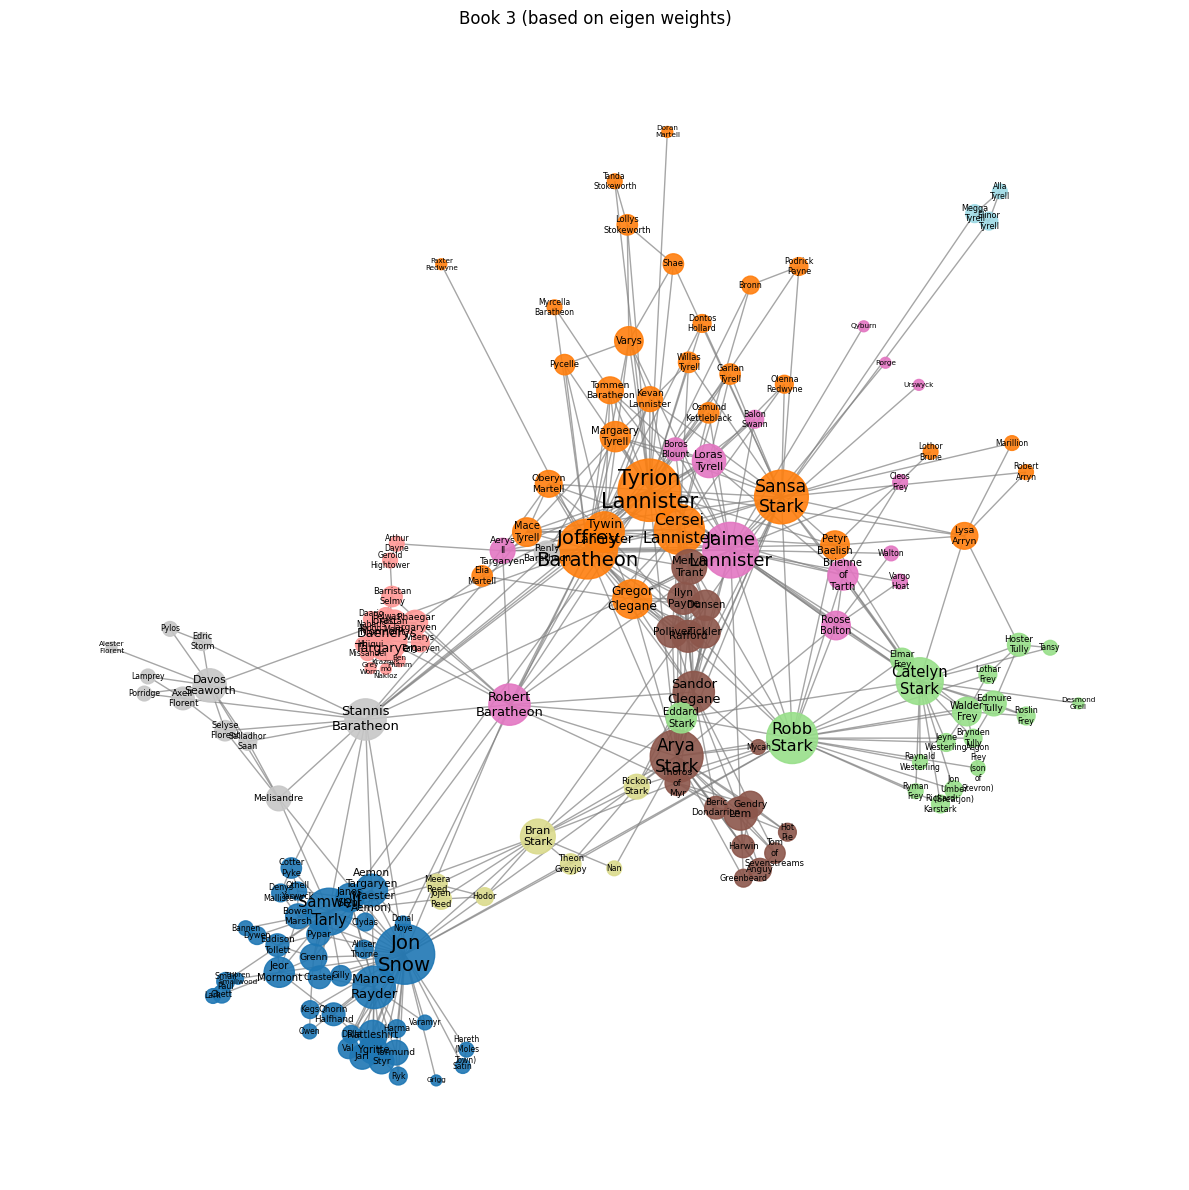

In [ ]:
# Book 3, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book3.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',

    )
print(sorted(ec.items(), key = lambda x :-x[1])[:10])
print(top_labels[:10])
plt.axis('off')
plt.title("Book 3 (based on eigen weights)")
plt.tight_layout()
plt.show()

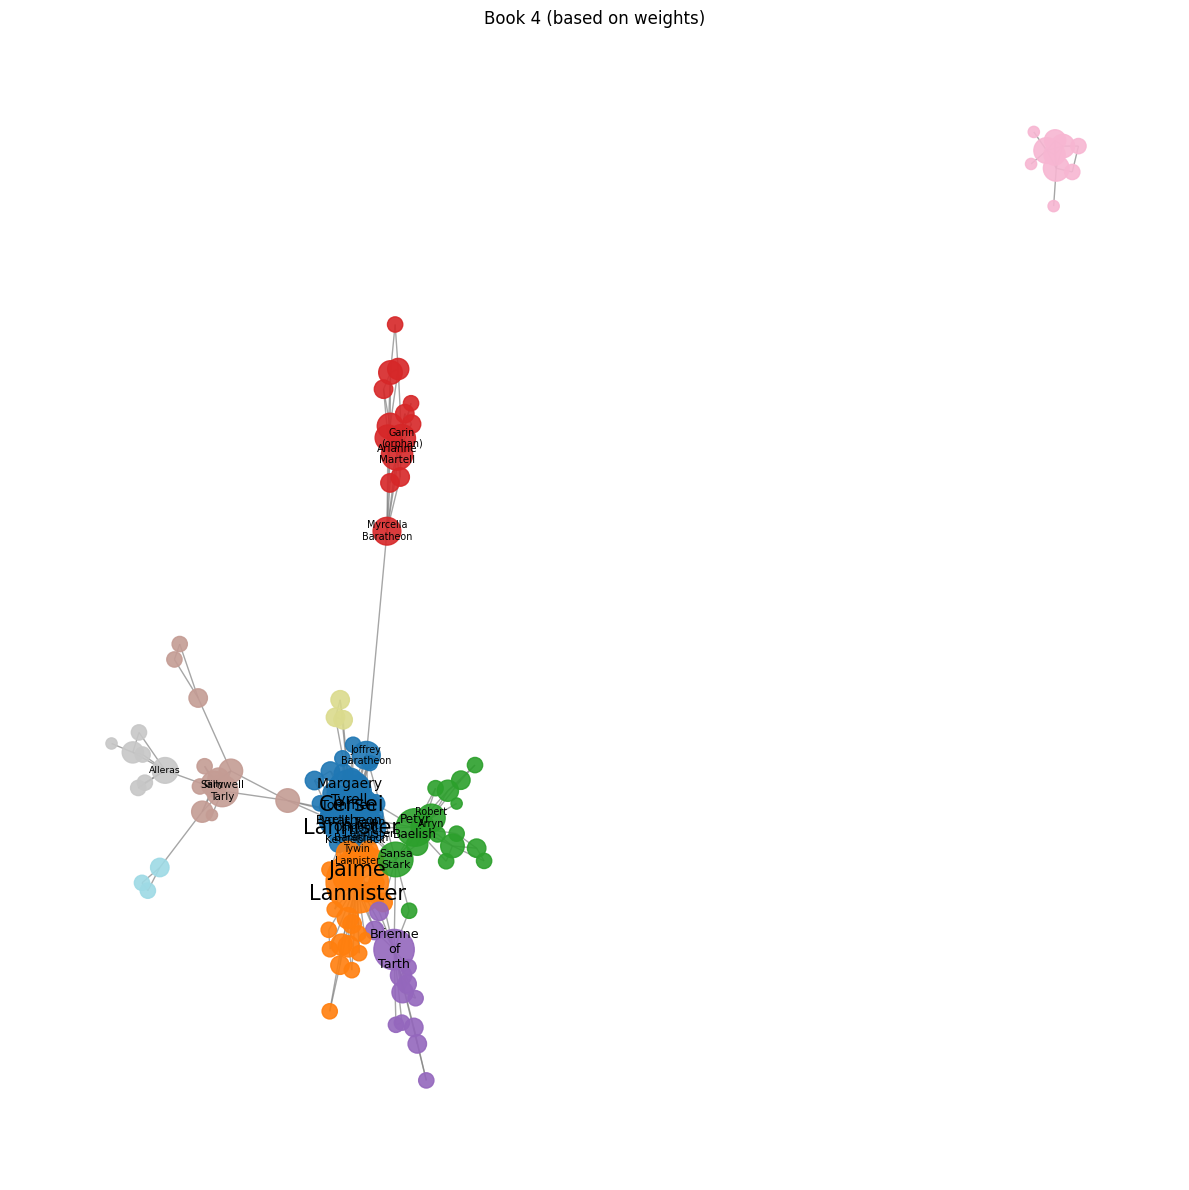

In [ ]:
# Book 4, distance = weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book4.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("Book 4 (based on weights)")
plt.tight_layout()
plt.show()

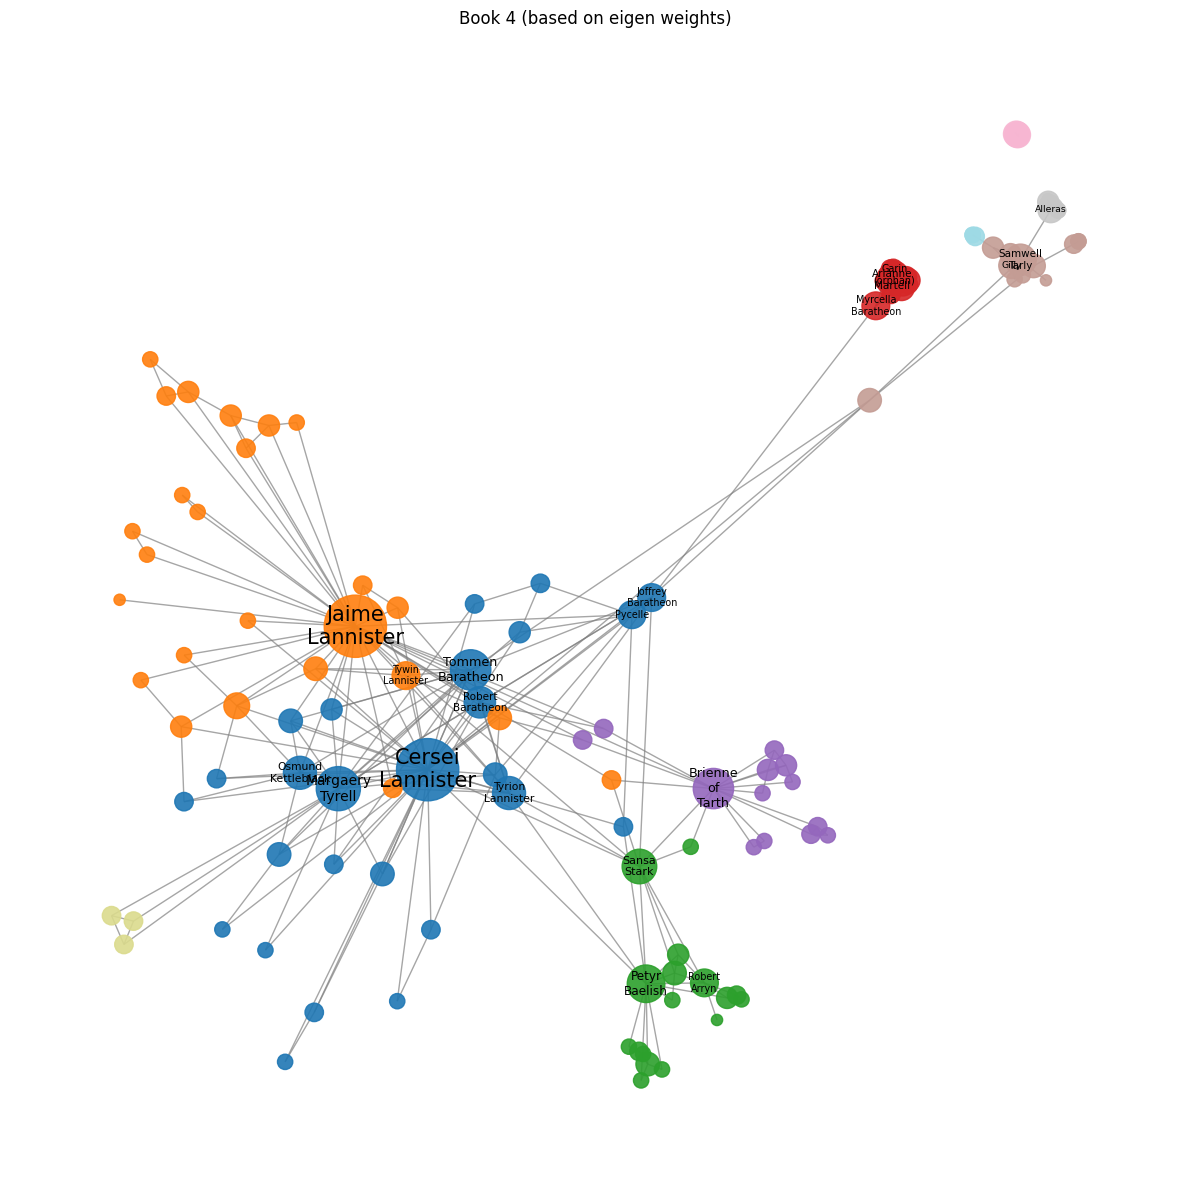

In [ ]:
# Book 4, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book4.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black'
    )

plt.axis('off')
plt.title("Book 4 (based on eigen weights)")
plt.tight_layout()
plt.show()

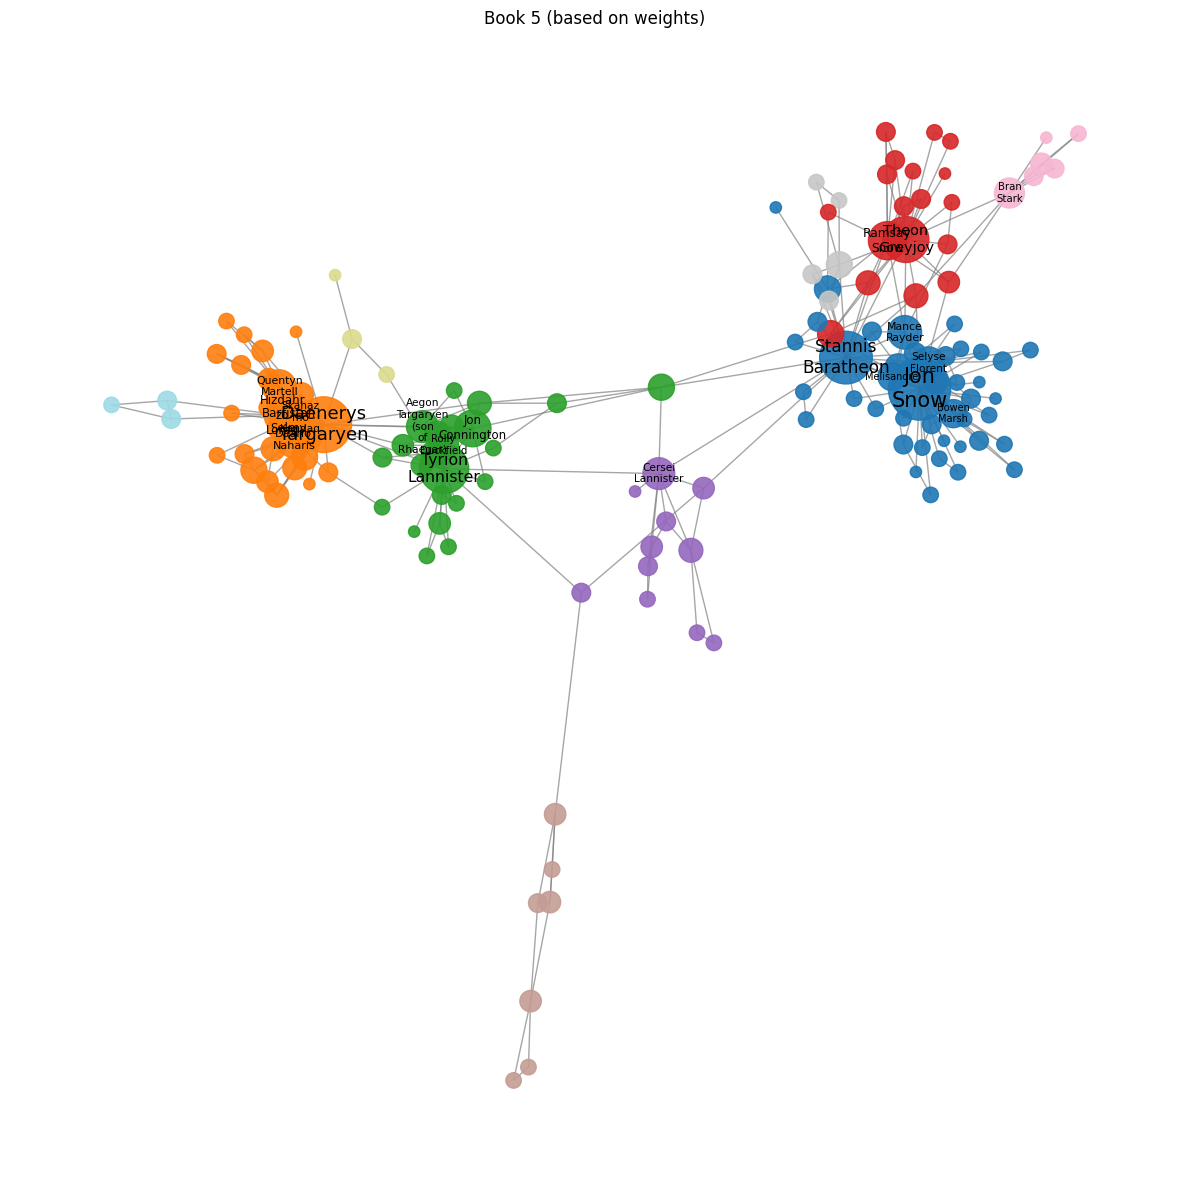

In [ ]:
# Book 5, distance = weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book5.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("Book 5 (based on weights)")
plt.tight_layout()
plt.show()

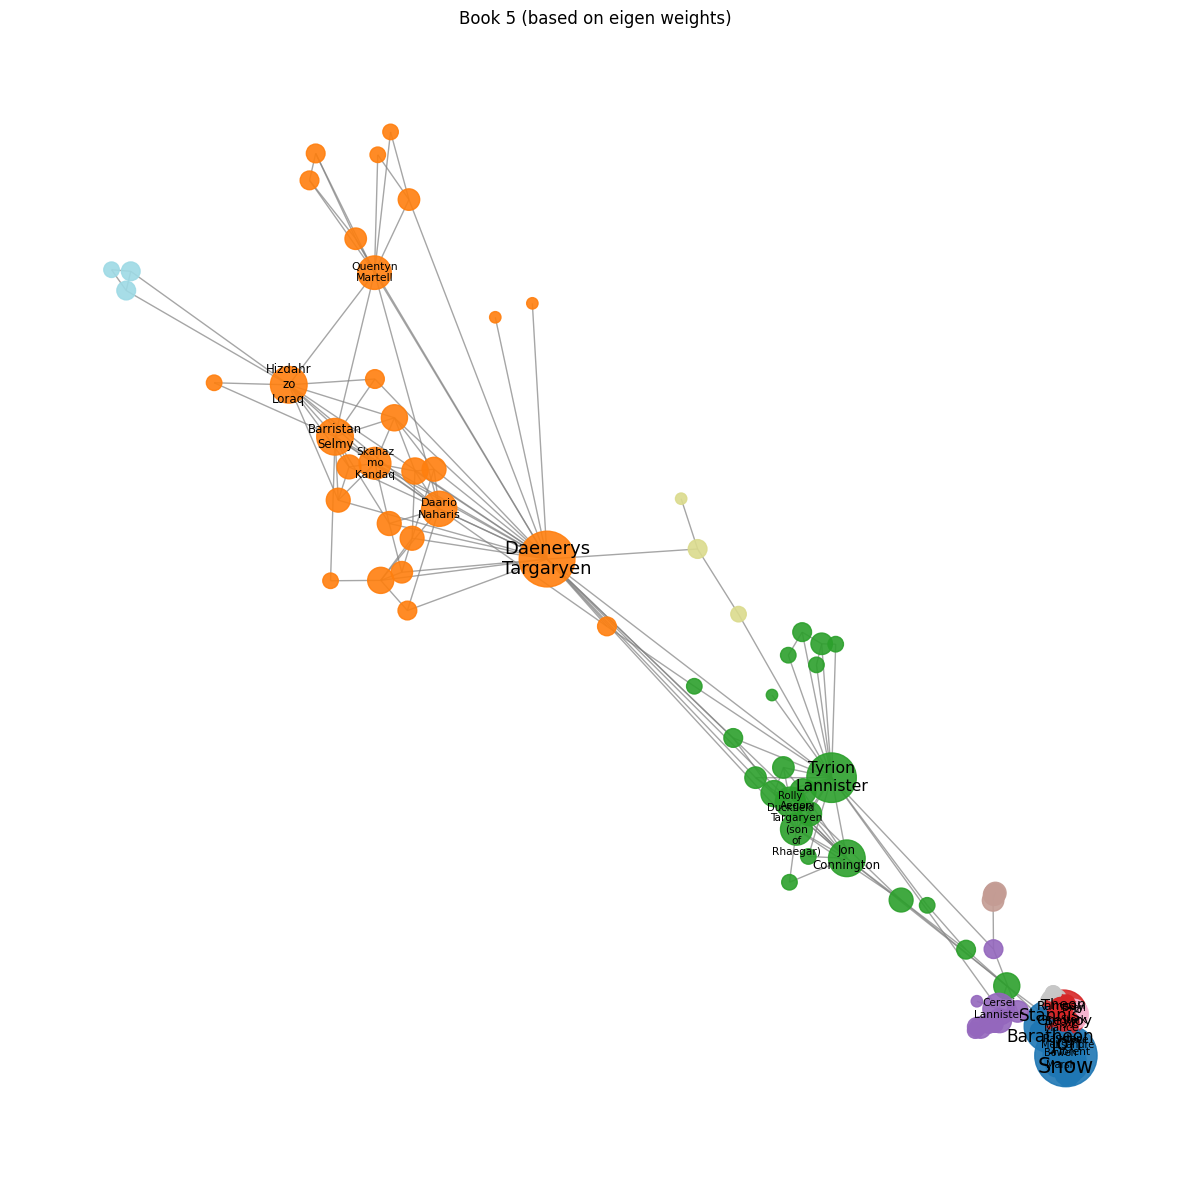

In [ ]:
# Book 5, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/Untitled Folder/book5.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("Book 5 (based on eigen weights)")
plt.tight_layout()
plt.show()

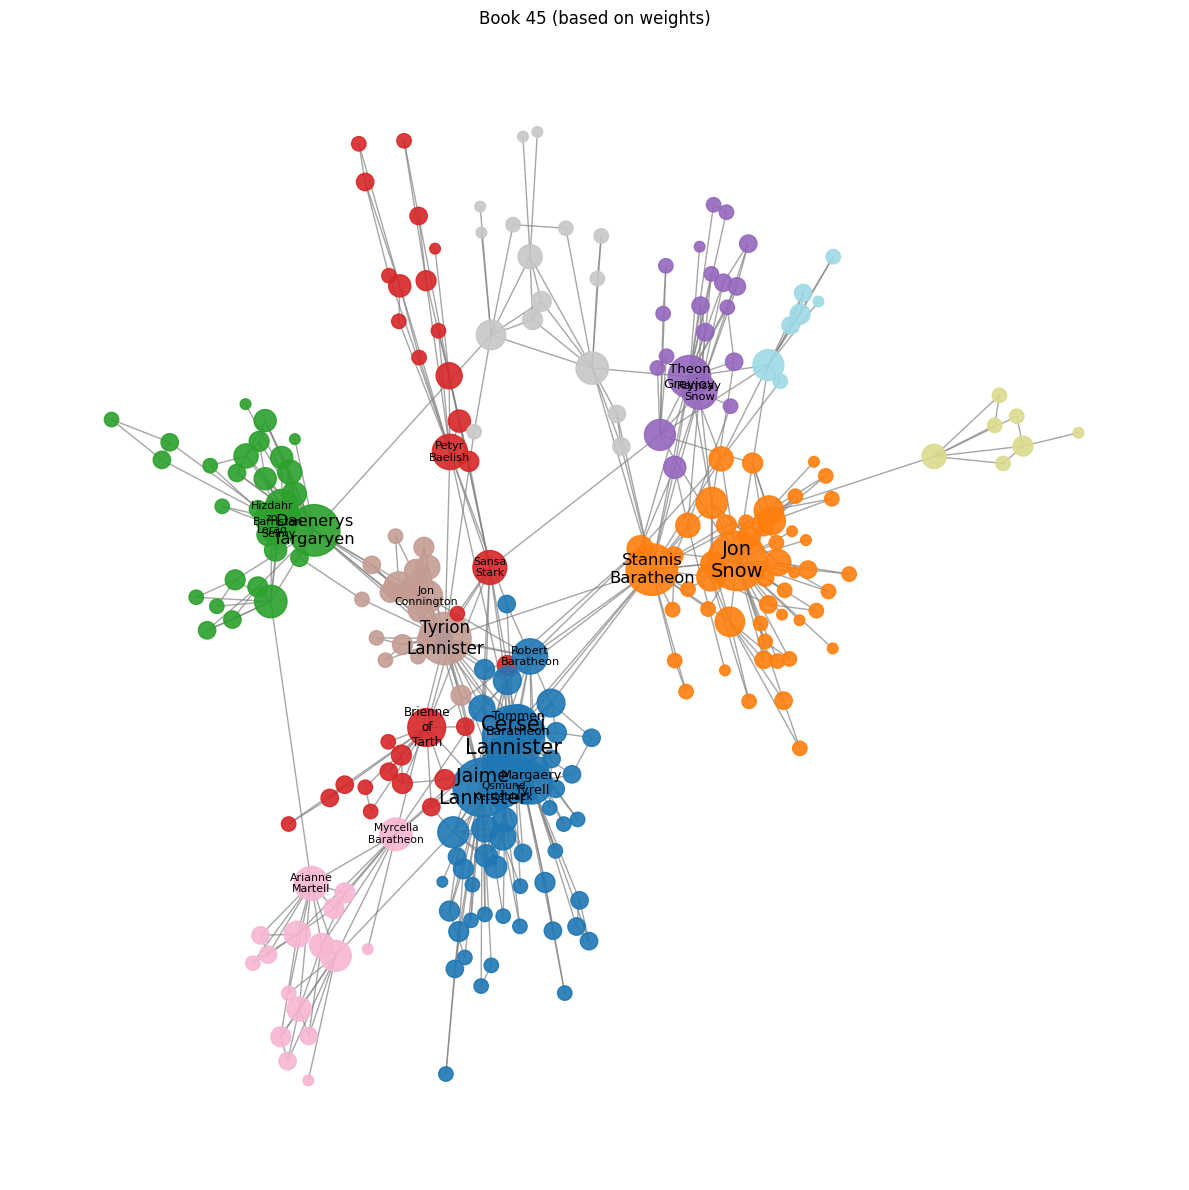

In [ ]:
# Book 45, distance = weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/asoiaf-book45-edges.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("Book 45 (based on weights)")
plt.tight_layout()
plt.show()

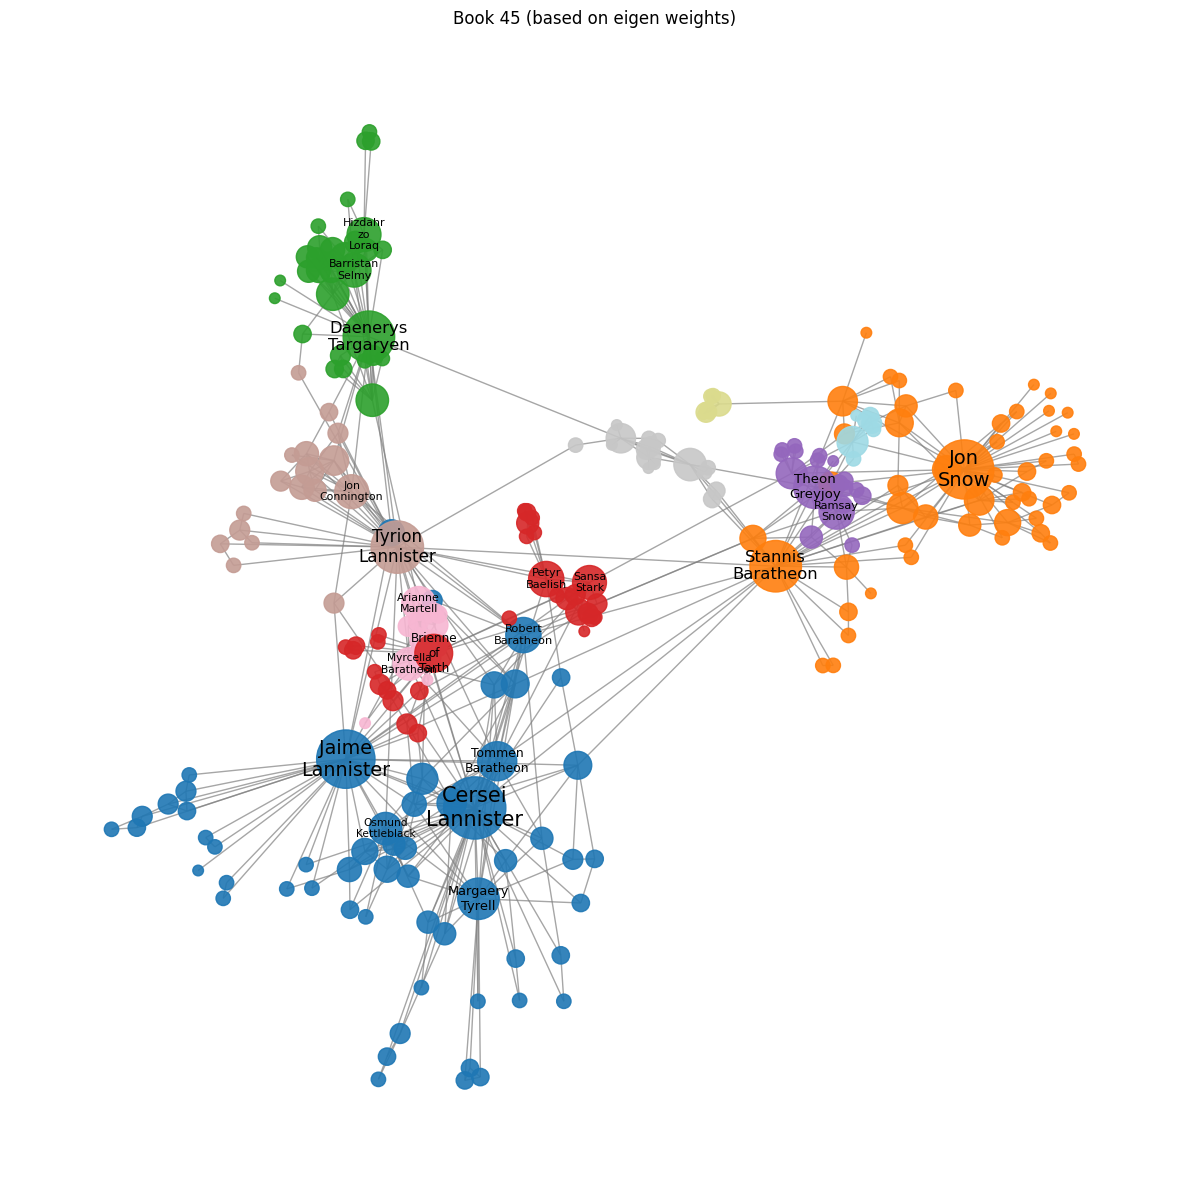

In [ ]:
# Book 45, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/asoiaf-book45-edges.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 5
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 10
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("Book 45 (based on eigen weights)")
plt.tight_layout()
plt.show()

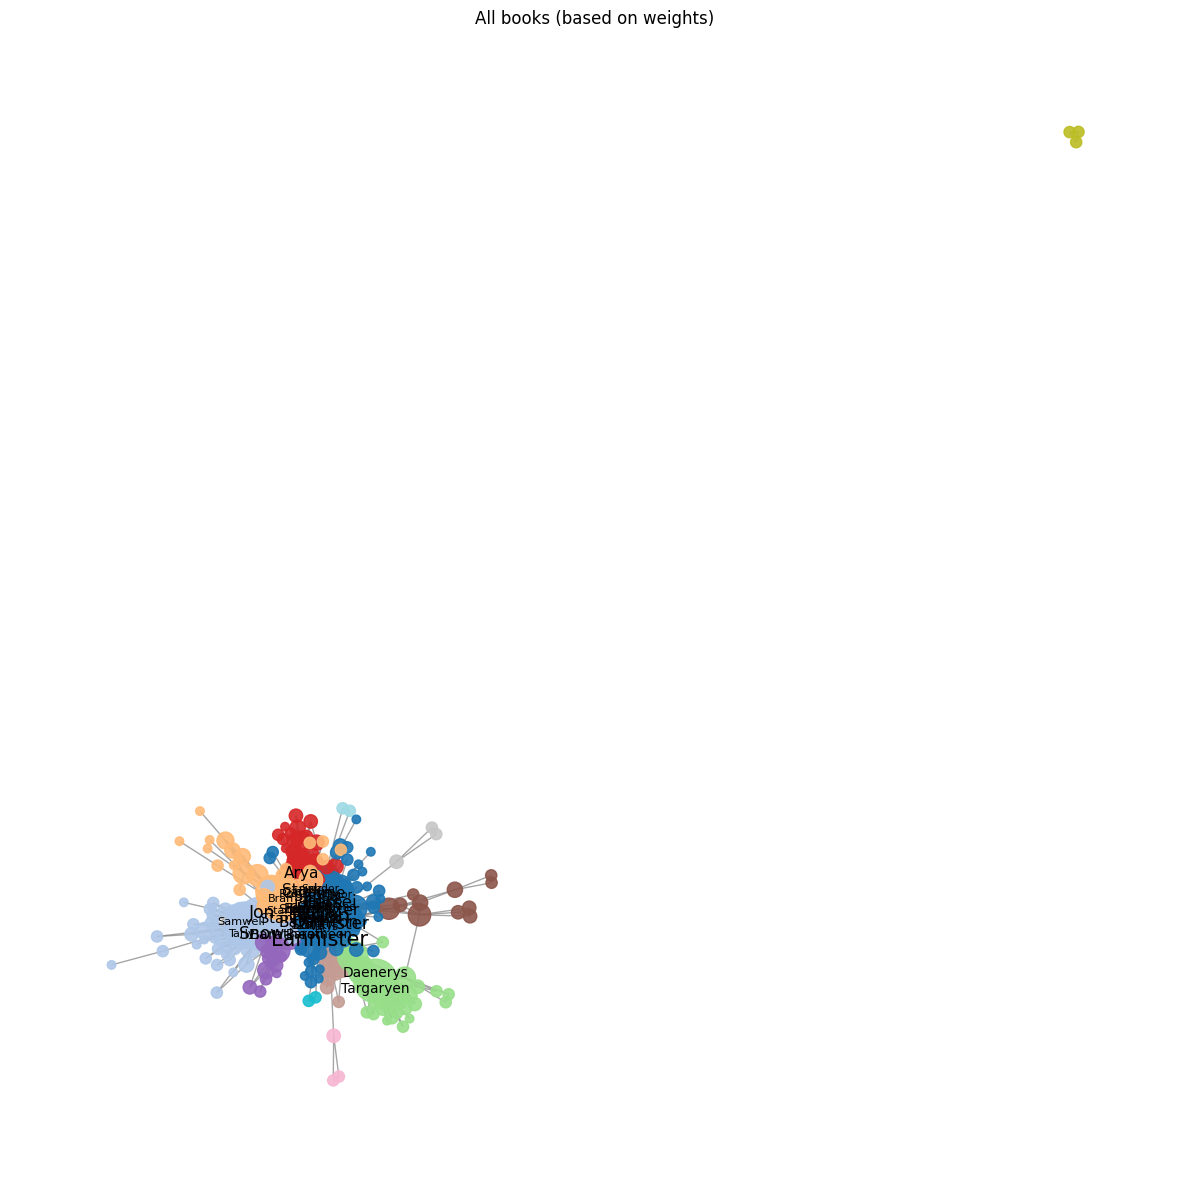

In [ ]:
# All books, distance = weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/asoiaf-all-edges.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 8
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 15
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:20]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# for n in labels:
#     labels[n] = n.replace('-', '\n')
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=5 + (deg[n]/max_deg)*10,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# # 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize=5 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )

plt.axis('off')
plt.title("All books (based on weights)")
plt.tight_layout()
plt.show()

[('Tyrion-Lannister', 0.3856727637058116), ('Cersei-Lannister', 0.36350374114794254), ('Joffrey-Baratheon', 0.3490830129067809), ('Robert-Baratheon', 0.2858691808499349), ('Eddard-Stark', 0.2857339356847988), ('Sansa-Stark', 0.2780666233464599), ('Jaime-Lannister', 0.21567395785066457), ('Robb-Stark', 0.17164264376492805), ('Jon-Snow', 0.16425817084621772), ('Catelyn-Stark', 0.16420877502987868)]
['Tyrion-Lannister', 'Jon-Snow', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Arya-Stark', 'Jaime-Lannister', 'Sansa-Stark', 'Stannis-Baratheon', 'Eddard-Stark', 'Daenerys-Targaryen']


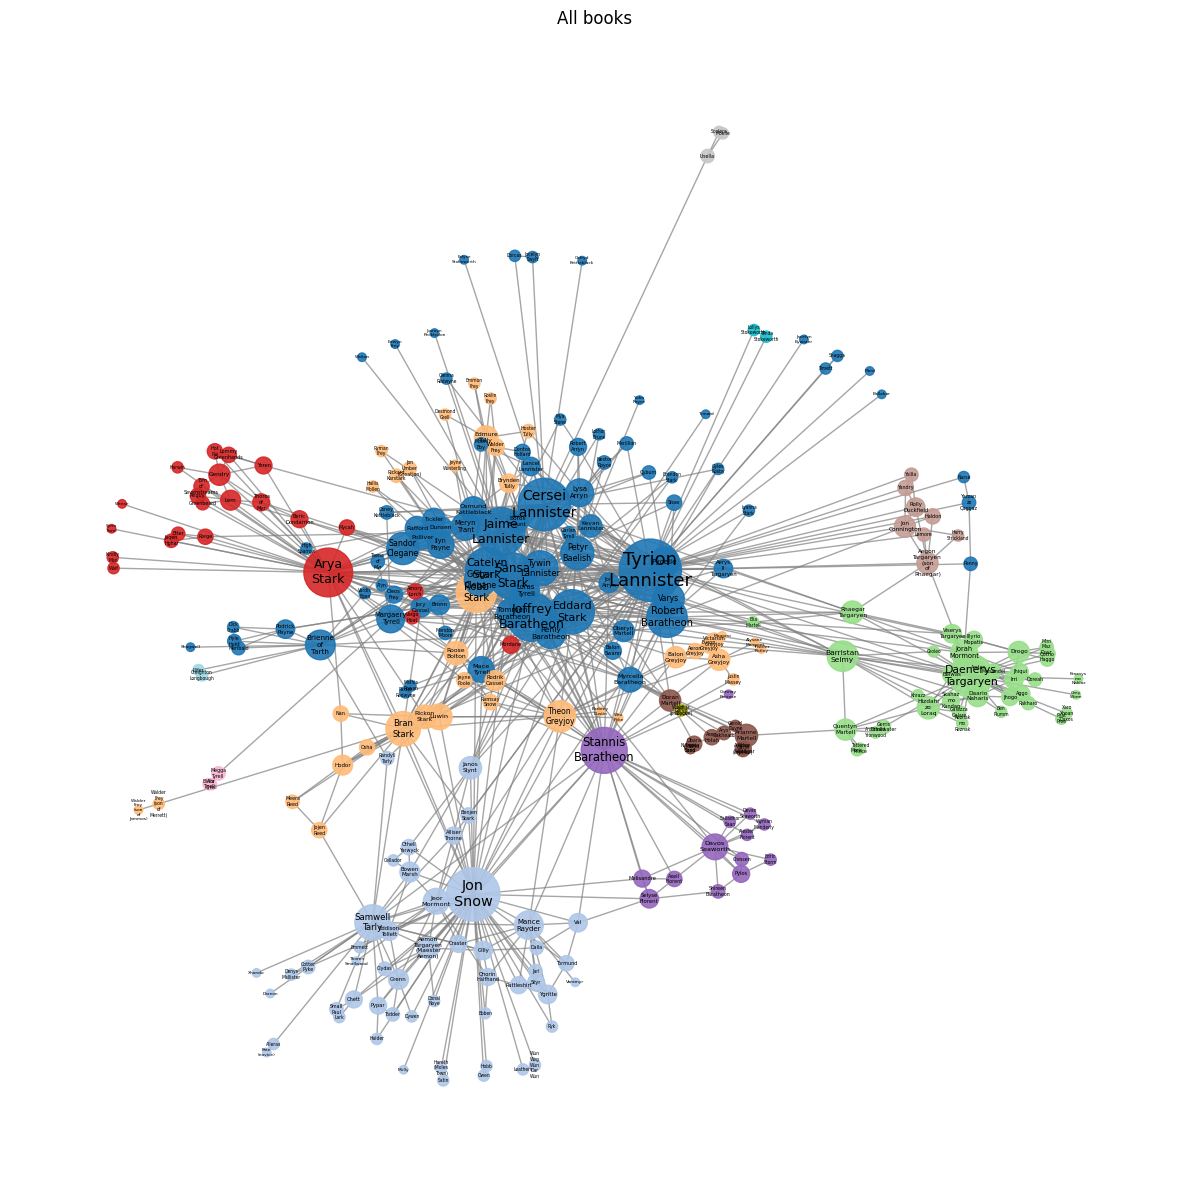

In [ ]:
# All Books, distance = eigen centrality + weight, community_forming menthod = Louvian
import pandas as pd
import networkx as nx
import math
from matplotlib import patheffects
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# 1) Load your data
df = pd.read_csv("/content/asoiaf-all-edges.csv")
# must have columns: Source, Target, weight

# 2) Build the graph (undirected)
G = nx.from_pandas_edgelist(
    df,
    source='Source',
    target='Target',
    edge_attr='weight',
    create_using=nx.Graph()
)

# 2a) filter edges by weight
edge_thresh = 8
to_remove = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d['weight'] < edge_thresh
]
G.remove_edges_from(to_remove)

# 2b) filter edges by degree
deg = dict(G.degree(weight='weight'))
node_thresh = 15
low_deg = [n for n, w in deg.items() if w < node_thresh]
G.remove_nodes_from(low_deg)

# now G contains only edges ≥ edge_thresh and nodes of
# weighted-degree ≥ node_thresh


# 3) Community detection (Fast-Greedy / Greedy modularity)
from networkx.algorithms.community import greedy_modularity_communities
# this runs the CNM “fast-greedy” modularity maximization
comms = greedy_modularity_communities(G, weight='weight')

partition = {}
for ci, com in enumerate(comms):
    for node in com:
        partition[node] = ci
# color index per node
node_colors = [partition[n] for n in G.nodes()]

# … after you’ve built and filtered G …

# 3.1) Compute eigenvector‐centrality (using your original edge‐weights for centrality!)
from networkx.algorithms.centrality import eigenvector_centrality

ec = eigenvector_centrality(G, weight='weight')
# ec is a dict: node → centrality score (sums to 1)

# 3.2) For each edge, compute an inverse‐centrality weight
#      so that edges between very central nodes get a SMALLER weight
#      (i.e. weaker “spring” = longer rest‐length)
for u, v, d in G.edges(data=True):
    avg_c = (ec[u] + ec[v]) / 2.0
    # avoid division by zero (in case a node got zero eigencentrality)
    d['ec_weight'] = 1.0 / (avg_c + 1e-6)

# 4) Compute layout using the new edge‐attribute
pos = nx.spring_layout(
    G,
    weight='ec_weight',  # use our inverse‐centrality attr here
    k=0.6,
    scale=6.0,
    iterations=500,
    seed=42
)

# … then carry on with your size, color, and drawing code unchanged …


# 5) Compute visual attributes
# 5a) Node sizes by weighted degree
deg       = dict(G.degree(weight=d['weight']))
max_deg   = max(deg.values())
node_sizes = [10 + (deg[n]/max_deg)*2000 for n in G.nodes()]

# 5b) Edge widths scaled from weight
weights   = [d['weight'] for _,_,d in G.edges(data=True)]
min_w, max_w = min(weights), max(weights)
edge_widths = 1

# 5c) Decide which nodes to label (top 10 by degree)
top_labels = sorted(deg, key=deg.get, reverse=True)[:]
label_pos  = {n: pos[n] for n in top_labels}

# 6) Draw
plt.figure(figsize=(12,12))

# 6a) Edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='gray'
)

# 6b) Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    alpha=0.9
)

# # 6c) Labels for all nodes
# labels = {n: n for n in top_labels}   # a dict: node → its own name
# nx.draw_networkx_labels(
#     G, pos,
#     labels=labels,
#     font_size=6,               # pick a size that won’t overwhelm
#     font_color='black',
#     font_family='sans-serif',
#     verticalalignment='center'
# )

# (Optionally re-draw your top-10 with bigger font or effects)


# 6c) Labels (only on the top hubs)
for n in top_labels:
    m = n.replace('-', '\n')
    x, y = pos[n]
    plt.text(
        x, y, m,
        fontsize= 3 + (deg[n]/max_deg)*10,
        ha='center', va='center',
        color='black',
    )
print(sorted(ec.items(), key = lambda x :-x[1])[:10])
print(top_labels[:10])
plt.axis('off')
plt.title("All books")
plt.tight_layout()
plt.show()


In [ ]:
# unweighted network tests
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# --- CONFIGURE THIS LIST WITH YOUR SIX FILE PATHS ---
files = [
    "/content/Untitled Folder/book1.csv",
    "/content/Untitled Folder/book2.csv",
    "/content/Untitled Folder/book3.csv",
    "/content/asoiaf-book45-edges.csv",
    "/content/asoiaf-all-edges.csv"  # e.g. full-network or summary file
]

# If your CSVs have different column names, adjust these:
SRC_COL = "Source"
TGT_COL = "Target"

for path in files:
    # 1) Load edgelist and build undirected graph
    df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(df, source=SRC_COL, target=TGT_COL, edge_attr='weight')

    # 2) Compute metrics
    # 2a) Degree (raw)
    deg = dict(G.degree())
    top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]

    # 2b) Eigenvector centrality
    #    you can tweak max_iter / tol if it fails to converge
    eig = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    top_eig = sorted(eig.items(), key=lambda x: x[1], reverse=True)[:10]

    # 2c) Betweenness centrality
    btw = nx.betweenness_centrality(G, normalized=True)
    top_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:10]

    # 3) Detect communities & compute modularity
    comms = list(greedy_modularity_communities(G))
    Q = modularity(G, comms)

    # 4) Print results
    print(f"\n=== {path} ===")
    print(f"Modularity (Greedy): {Q:.4f}\n")

    print("Top 10 by degree:")
    for node, val in top_deg:
        print(f"  {node:<15} {val:>4}")
    print()

    print("Top 10 by eigenvector centrality:")
    for node, val in top_eig:
        print(f"  {node:<15} {val:.4f}")
    print()

    print("Top 10 by betweenness centrality:")
    for node, val in top_btw:
        print(f"  {node:<15} {val:.4f}")
    print("-" * 40)



=== /content/Untitled Folder/book1.csv ===
Modularity (Greedy): 0.4314

Top 10 by degree:
  Eddard-Stark      66
  Robert-Baratheon   50
  Tyrion-Lannister   46
  Catelyn-Stark     43
  Jon-Snow          37
  Robb-Stark        35
  Sansa-Stark       35
  Bran-Stark        32
  Cersei-Lannister   30
  Joffrey-Baratheon   30

Top 10 by eigenvector centrality:
  Eddard-Stark    0.2964
  Robert-Baratheon 0.2695
  Sansa-Stark     0.2316
  Tyrion-Lannister 0.2252
  Joffrey-Baratheon 0.2208
  Cersei-Lannister 0.2164
  Catelyn-Stark   0.2126
  Petyr-Baelish   0.2015
  Jaime-Lannister 0.1950
  Bran-Stark      0.1938

Top 10 by betweenness centrality:
  Eddard-Stark    0.2760
  Robert-Baratheon 0.2108
  Tyrion-Lannister 0.1902
  Jon-Snow        0.1740
  Catelyn-Stark   0.1545
  Daenerys-Targaryen 0.0882
  Robb-Stark      0.0730
  Drogo           0.0655
  Bran-Stark      0.0546
  Sansa-Stark     0.0382
----------------------------------------

=== /content/Untitled Folder/book2.csv ===
Modularit

In [ ]:
# Weighted network tests
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# --- CONFIGURE THIS LIST WITH YOUR SIX FILE PATHS ---
files = [
    "/content/Untitled Folder/book1.csv",
    "/content/Untitled Folder/book2.csv",
    "/content/Untitled Folder/book3.csv",
    "/content/asoiaf-book45-edges.csv",
    "/content/asoiaf-all-edges.csv"  # e.g. full-network or summary file
]

# If your CSVs use different column names, change these:
SRC_COL    = "Source"
TGT_COL    = "Target"
WEIGHT_COL = "weight"

for path in files:
    # 1) Load edgelist and build a weighted undirected graph
    df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(
        df,
        source=SRC_COL,
        target=TGT_COL,
        edge_attr=WEIGHT_COL,
        create_using=nx.Graph()
    )

    # 2) Compute weighted metrics
    # 2a) Weighted degree
    deg_w = dict(G.degree(weight=WEIGHT_COL))
    top_deg = sorted(deg_w.items(), key=lambda x: x[1], reverse=True)[:10]

    # 2b) Eigenvector centrality (takes weights into account)
    eig_w = nx.eigenvector_centrality(
        G,
        max_iter=1000,
        tol=1e-06,
        weight=WEIGHT_COL
    )
    top_eig = sorted(eig_w.items(), key=lambda x: x[1], reverse=True)[:10]

    # 2c) Betweenness centrality (weighted)
    btw_w = nx.betweenness_centrality(
        G,
        normalized=True,
        weight=WEIGHT_COL
    )
    top_btw = sorted(btw_w.items(), key=lambda x: x[1], reverse=True)[:10]

    # 3) Community detection & weighted modularity
    comms = list(greedy_modularity_communities(G, weight=WEIGHT_COL))
    Q = modularity(G, comms, weight=WEIGHT_COL)

    # 4) Print results
    print(f"\n=== {path} ===")
    print(f"Weighted modularity (Greedy): {Q:.4f}\n")

    print("Top 10 by weighted degree:")
    for node, val in top_deg:
        print(f"  {node:<15} {val:.2f}")
    print()

    print("Top 10 by eigenvector centrality:")
    for node, val in top_eig:
        print(f"  {node:<15} {val:.4f}")
    print()

    print("Top 10 by betweenness centrality:")
    for node, val in top_btw:
        print(f"  {node:<15} {val:.4f}")
    print("-" * 50)



=== /content/Untitled Folder/book1.csv ===
Weighted modularity (Greedy): 0.5063

Top 10 by weighted degree:
  Eddard-Stark    1284.00
  Robert-Baratheon 941.00
  Jon-Snow        784.00
  Tyrion-Lannister 650.00
  Sansa-Stark     545.00
  Bran-Stark      531.00
  Catelyn-Stark   520.00
  Robb-Stark      516.00
  Daenerys-Targaryen 443.00
  Arya-Stark      430.00

Top 10 by eigenvector centrality:
  Eddard-Stark    0.5607
  Robert-Baratheon 0.5135
  Cersei-Lannister 0.2374
  Sansa-Stark     0.1859
  Petyr-Baelish   0.1826
  Catelyn-Stark   0.1823
  Joffrey-Baratheon 0.1697
  Jon-Snow        0.1669
  Varys           0.1547
  Tyrion-Lannister 0.1518

Top 10 by betweenness centrality:
  Robert-Baratheon 0.2270
  Eddard-Stark    0.1911
  Tyrion-Lannister 0.1558
  Robb-Stark      0.1035
  Catelyn-Stark   0.1033
  Jon-Snow        0.0919
  Jaime-Lannister 0.0793
  Rodrik-Cassel   0.0780
  Drogo           0.0695
  Jorah-Mormont   0.0635
--------------------------------------------------

=== /c

In [ ]:
# to check the difference between weighted and unweighted
files = [
    "/content/asoiaf-book45-edges.csv" # e.g. full-network or summary file
]

# If your CSVs use different column names, change these:
SRC_COL    = "Source"
TGT_COL    = "Target"
WEIGHT_COL = "weight"

for path in files:
    # 1) Load edgelist and build a weighted undirected graph
    df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(
        df,
        source=SRC_COL,
        target=TGT_COL,
        edge_attr=WEIGHT_COL,
        create_using=nx.Graph()
    )
# un-weighted:
top_deg = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

# weighted:
top_str = sorted(G.degree(weight='weight'),
                 key=lambda x: x[1], reverse=True)[:10]

print("Un-weighted degree top 10:", top_deg)
print("Weighted degree (strength) top 10:", top_str)

Un-weighted degree top 10: [('Jaime-Lannister', 67), ('Cersei-Lannister', 66), ('Jon-Snow', 65), ('Daenerys-Targaryen', 58), ('Stannis-Baratheon', 57), ('Tyrion-Lannister', 52), ('Theon-Greyjoy', 35), ('Brienne-of-Tarth', 29), ('Sansa-Stark', 26), ('Barristan-Selmy', 26)]
Weighted degree (strength) top 10: [('Cersei-Lannister', 930), ('Jon-Snow', 857), ('Daenerys-Targaryen', 721), ('Tyrion-Lannister', 612), ('Jaime-Lannister', 611), ('Stannis-Baratheon', 510), ('Tommen-Baratheon', 334), ('Theon-Greyjoy', 319), ('Hizdahr-zo-Loraq', 292), ('Margaery-Tyrell', 280)]


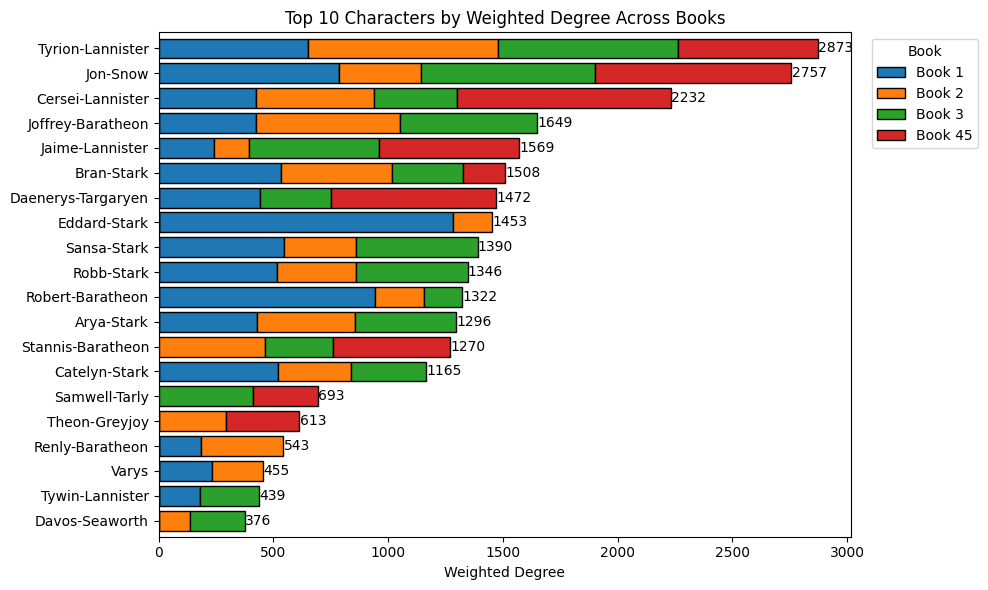

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# --- CONFIGURE THIS LIST WITH YOUR BOOK FILE PATHS ---
files = [
    "/content/Untitled Folder/book1.csv",
    "/content/Untitled Folder/book2.csv",
    "/content/Untitled Folder/book3.csv",
    "/content/asoiaf-book45-edges.csv",
]

SRC_COL    = "Source"
TGT_COL    = "Target"
WEIGHT_COL = "weight"

# This will hold the top-10 degree for each book
records = []

books = ['Book 1','Book 2','Book 3','Book 45']
for i, path in enumerate(files, start=1):
    # 1) Load edgelist and build weighted graph
    df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(
        df,
        source=SRC_COL,
        target=TGT_COL,
        edge_attr=WEIGHT_COL,
        create_using=nx.Graph()
    )

    # 2) Compute weighted degree
    deg_w = dict(G.degree(weight=WEIGHT_COL))
    top_deg = sorted(deg_w.items(), key=lambda x: x[1], reverse=True)[:20]

    # 3) Stash into records
    book_label = books[i-1]
    for name, value in top_deg:
        records.append({
            "character": name,
            "book":      book_label,
            "degree":    value
        })

# 4) Build DataFrame and pivot to wide form
df_plot = pd.DataFrame(records)

# Pivot so each row is a character, each col is one book
df_wide = df_plot.pivot_table(
    index="character",
    columns="book",
    values="degree",
    fill_value=0
)

# Compute total degree across books and pick top N overall
df_wide["total"] = df_wide.sum(axis=1)
df_wide = df_wide.sort_values("total", ascending=False).head(20)

# 5) Plot stacked horizontal bars

ax = df_wide[books].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    width=0.8,
    edgecolor="black"
)

# Annotate each bar with its total
for idx, (name, row) in enumerate(df_wide.iterrows()):
    ax.text(
        row["total"] + 1,      # shift a bit to the right
        idx,                   # y position
        f"{int(row['total'])}",# label
        va="center"
    )

ax.invert_yaxis()                # highest total on top
ax.legend(title="Book", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set_xlabel("Weighted Degree")
ax.set_ylabel("")
ax.set_title("Top 10 Characters by Weighted Degree Across Books")
plt.tight_layout()
plt.show()


/tmp/ipython-input-31-1057097567.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(books))


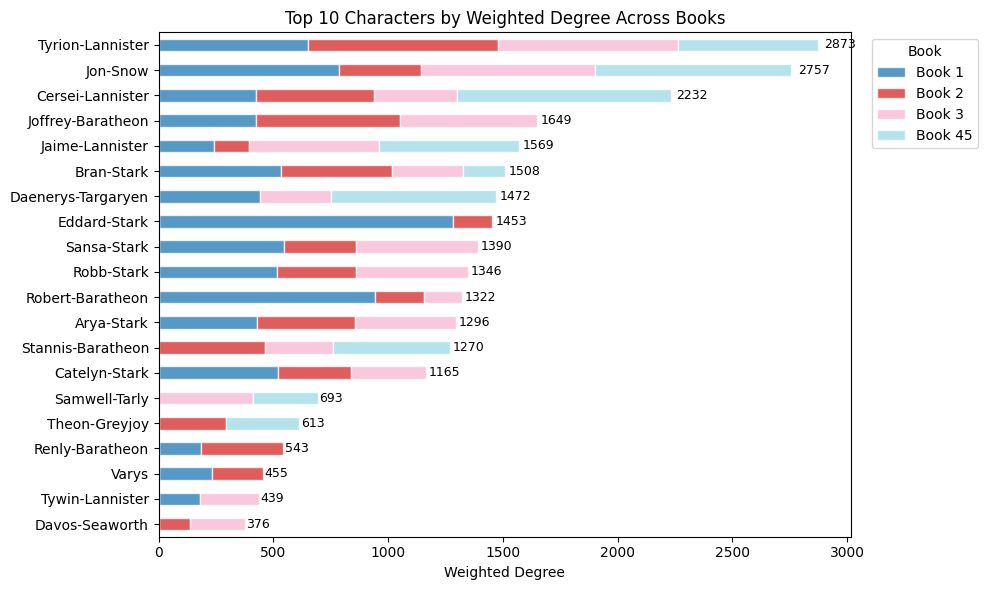

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# --- CONFIGURE THIS LIST WITH YOUR BOOK FILE PATHS ---
files = [
    "/content/Untitled Folder/book1.csv",
    "/content/Untitled Folder/book2.csv",
    "/content/Untitled Folder/book3.csv",
    "/content/asoiaf-book45-edges.csv",
]

SRC_COL    = "Source"
TGT_COL    = "Target"
WEIGHT_COL = "weight"

# This will hold the top-10 degree for each book
records = []

books = ['Book 1','Book 2','Book 3','Book 45']
for i, path in enumerate(files, start=1):
    # 1) Load edgelist and build weighted graph
    df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(
        df,
        source=SRC_COL,
        target=TGT_COL,
        edge_attr=WEIGHT_COL,
        create_using=nx.Graph()
    )

    # 2) Compute weighted degree
    deg_w = dict(G.degree(weight=WEIGHT_COL))
    top_deg = sorted(deg_w.items(), key=lambda x: x[1], reverse=True)[:20]

    # 3) Stash into records
    book_label = books[i-1]
    for name, value in top_deg:
        records.append({
            "character": name,
            "book":      book_label,
            "degree":    value
        })

# 4) Build DataFrame and pivot to wide form
df_plot = pd.DataFrame(records)

# Pivot so each row is a character, each col is one book
df_wide = df_plot.pivot_table(
    index="character",
    columns="book",
    values="degree",
    fill_value=0
)

# Compute total degree across books and pick top N overall
df_wide["total"] = df_wide.sum(axis=1)
df_wide = df_wide.sort_values("total", ascending=False).head(20)

# 5) Plot stacked horizontal bars


# pick 1 color per book from the “tab20” palette
cmap = plt.cm.get_cmap("tab20", len(books))
colors = [cmap(i) for i in range(len(books))]

fig, ax = plt.subplots(figsize=(10, 6))

df_wide[books].plot(
    kind="barh",
    stacked=True,
    ax=ax,
    color=colors,
    alpha=0.75,           # semi-transparent
    edgecolor="white",    # white borders between segments
    linewidth=1
)

# annotate totals
for idx, (name, row) in enumerate(df_wide.iterrows()):
    total = row[books].sum()
    ax.text(
        total + total*0.01, idx,
        f"{int(total)}",
        va="center",
        fontsize=9
    )

ax.invert_yaxis()
ax.set_xlabel("Weighted Degree")
ax.set_ylabel("")
ax.set_title("Top 10 Characters by Weighted Degree Across Books")
ax.legend(title="Book", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [7]:
# unweighted network tests with community purity
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# --- CONFIGURE THIS LIST WITH YOUR FILE PATHS ---
files = [
    "/content/Untitled Folder/book1.csv",
    "/content/Untitled Folder/book2.csv",
    "/content/Untitled Folder/book3.csv",
    "/content/asoiaf-book45-edges.csv",
    "/content/asoiaf-all-edges.csv",
]

SRC_COL = "Source"
TGT_COL = "Target"

def assign_house(node):
    parts = node.split('-')
    return parts[-1] if len(parts) > 1 else None

def compute_purity(communities, house_lookup):
    results = []
    for i, community in enumerate(communities):
        houses = [house_lookup.get(n) for n in community if house_lookup.get(n) is not None]
        total = len(community)
        if houses:
            dominant = max(set(houses), key=houses.count)
            dominant_count = houses.count(dominant)
            purity = dominant_count / total
        else:
            dominant = "None"
            purity = 0
        results.append({
            "Community": i + 1,
            "Purity": round(purity, 3),
            "Dominant House": dominant,
            "Size": total
        })
    return results

for path in files:
    # 1) Load and build graph
    df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(df, source=SRC_COL, target=TGT_COL, edge_attr='weight')

    # 2) Metrics
    deg = dict(G.degree())
    eig = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    btw = nx.betweenness_centrality(G, normalized=True)

    # 3) Community detection
    comms = list(greedy_modularity_communities(G))
    Q = modularity(G, comms)

    # 4) House mapping
    house_lookup = {node: assign_house(node) for node in G.nodes}

    # 5) Purity calculation
    purity_stats = compute_purity(comms, house_lookup)

    # 6) Display results
    print(f"\n=== {path} ===")
    print(f"Modularity (Greedy): {Q:.4f}")
    print("Community Purity Stats:")
    for entry in purity_stats:
        print(f"  Community {entry['Community']:>2}: Purity = {entry['Purity']:.2f}, "
              f"Size = {entry['Size']}, Dominant House = {entry['Dominant House']}")

    print("\nTop 10 by degree:")
    for node, val in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {node:<20} {val:>4}")

    print("\nTop 10 by eigenvector centrality:")
    for node, val in sorted(eig.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {node:<20} {val:.4f}")

    print("\nTop 10 by betweenness centrality:")
    for node, val in sorted(btw.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {node:<20} {val:.4f}")

    print("-" * 50)


=== /content/Untitled Folder/book1.csv ===
Modularity (Greedy): 0.4314
Community Purity Stats:
  Community  1: Purity = 0.07, Size = 61, Dominant House = Lannister
  Community  2: Purity = 0.17, Size = 35, Dominant House = Baratheon
  Community  3: Purity = 0.13, Size = 31, Dominant House = Stark
  Community  4: Purity = 0.08, Size = 26, Dominant House = Tarly
  Community  5: Purity = 0.14, Size = 22, Dominant House = Targaryen
  Community  6: Purity = 0.17, Size = 6, Dominant House = Umar
  Community  7: Purity = 1.00, Size = 3, Dominant House = Frey

Top 10 by degree:
  Eddard-Stark           66
  Robert-Baratheon       50
  Tyrion-Lannister       46
  Catelyn-Stark          43
  Jon-Snow               37
  Robb-Stark             35
  Sansa-Stark            35
  Bran-Stark             32
  Cersei-Lannister       30
  Joffrey-Baratheon      30

Top 10 by eigenvector centrality:
  Eddard-Stark         0.2964
  Robert-Baratheon     0.2695
  Sansa-Stark          0.2316
  Tyrion-Lanniste